# Document Retrival with Follow up Detector (DR.FUD)

In this method we use a FCN to detect wheter a question is a follow up of the previous question, meaning that the document is the same of not. If the document is the same, we use the previous answer's document for this question also.

We used LaBSE model for out embeddings. For computing title embedding similarities we used cosine similarity between query embeddings and each document's title embedding.

# Dataset
## Dataset Description

- **mutldoc2dial_doc.json** contains the documents that are indexed by key `domain` and `doc_id` . Each document instance includes the following,

  - `doc_id`: the ID of a document;
  - `title`: the title of the document;
  - `domain`: the domain of the document;
  - `doc_text`: the text content of the document (without HTML markups);
  - `doc_html_ts`: the document content with HTML markups and the annotated spans that are indicated by `text_id` attribute, which corresponds to `id_sp`.
  - `doc_html_raw`: the document content with HTML markups and without span annotations.
  - `spans`: key-value pairs of all spans in the document, with `id_sp` as key. Each span includes the following,
    - `id_sp`: the id of a  span as noted by `text_id` in  `doc_html_ts`;
    - `start_sp`/  `end_sp`: the start/end position of the text span in `doc_text`;
    - `text_sp`: the text content of the span.
    - `id_sec`: the id of the (sub)section (e.g. `<p>`) or title (`<h2>`) that contains the span.
    - `start_sec` / `end_sec`: the start/end position of the (sub)section in `doc_text`.
    - `text_sec`: the text of the (sub)section.
    - `title`: the title of the (sub)section.
    - `parent_titles`: the parent titles of the `title`.

- **multidoc2dial_dial_train.json** and **multidoc2dial_dial_validation.json**  contain the training and dev split of dialogue data that are indexed by key `domain` . Please note: **For test split, we only include a dummy file in this version.**

  Each dialogue instance includes the following,

  - `dial_id`: the ID of a dialogue;
  - `turns`: a list of dialogue turns. Each turn includes,
    - `turn_id`: the time order of the turn;
    - `role`: either "agent" or "user";READ
    - `da`: dialogue act;
    - `references`: a list of spans with `id_sp` ,  `label` and `doc_id`. `references` is empty if a turn is for indicating previous user query not answerable or irrelevant to the document. **Note** that labels "*precondition*"/"*solution*" are fuzzy annotations that indicate whether a span is for describing a conditional context or a solution.
    - `utterance`: the human-generated utterance based on the dialogue scene.
Downloading the training dataset:

In [1]:
import json
with open('../../dataset/multidoc2dial/v1.0/multidoc2dial_doc.json', 'r') as f:
    multidoc2dial_doc = json.load(f)

## Constructing the Follow-up Dataset

``` history | question | is_follow_up```

is_follow_up: shows that the history's document is the same as the current question's.

In [78]:
def construct_followup_dataset(filepath):
    import json
    with open(filepath, 'r') as f:
        multidoc2dial_dial_train = json.load(f)
    
    separation_token = " <SEP> "
    historys = []
    questions = []
    combined = []
    labels = []

    for domain in multidoc2dial_dial_train['dial_data']:
        for dial in multidoc2dial_dial_train['dial_data'][domain]:
            prev_doc = ''
            prev_question = ''
            for turn in dial['turns']:
                if turn['role'] == "user":
                    current_question = turn['utterance']
                    historys.append(prev_question)
                    questions.append(current_question)
                    
                    combined.append(prev_question + separation_token + current_question)

                    current_doc = turn['references'][0]['doc_id']
                    labels.append(int(current_doc==prev_doc))

                    prev_doc, prev_question = current_doc, current_question
                    
    return historys, questions, combined, labels



In [79]:
import pandas as pd

train_history, train_questions, train_combined, train_labels = construct_followup_dataset('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_train.json')
test_history, test_questions, test_combined, test_labels = construct_followup_dataset('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_validation.json')

train_dict_dataset = {"history":train_history, "question": train_questions, "combined": train_combined, "followup": train_labels}
test_dict_dataset = {"history":test_history, "question": test_questions, "combined": test_combined, "followup": test_labels}

train_df = pd.DataFrame(train_dict_dataset)
test_df = pd.DataFrame(test_dict_dataset)

In [85]:
max([len(x["combined"].split()) for _, x in test_df.iterrows()])

74

In [80]:
train_df

,history,question,combined,followup
0,,"Hello, I forgot o update my address, can you h...","<SEP> Hello, I forgot o update my address, ca...",0
1,"Hello, I forgot o update my address, can you h...",Can I do my DMV transactions online?,"Hello, I forgot o update my address, can you h...",1
2,Can I do my DMV transactions online?,You've got it. Another query about DMV. What h...,Can I do my DMV transactions online? <SEP> You...,0
3,You've got it. Another query about DMV. What h...,"Besides that, will I receive a notice?",You've got it. Another query about DMV. What h...,1
4,"Besides that, will I receive a notice?",If you submit the affidavit?,"Besides that, will I receive a notice? <SEP> I...",1
...,...,...,...,...
23394,"By the way, who can I contact to give me infor...",What if I've fallen behind on one or more loan...,"By the way, who can I contact to give me infor...",0
23395,What if I've fallen behind on one or more loan...,I have another question regarding the Military...,What if I've fallen behind on one or more loan...,0
23396,I have another question regarding the Military...,something else I want to ask about FAFSA. What...,I have another question regarding the Military...,0
23397,something else I want to ask about FAFSA. What...,How can I make a payment by post?,something else I want to ask about FAFSA. What...,1


## Encoding the sentences
We use the LaBSE which is a Language-agnostic BERT Sentence Encoder (LaBSE) is a BERT-based model trained for sentence embedding for 109 languages. The pre-training process combines masked language modeling with translation language modeling. The model is useful for getting multilingual sentence embeddings and for bi-text retrieval.

In [47]:
%pip install --quiet transformers datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import numpy as np
import torch
from torch.nn.functional import normalize

from tqdm import tqdm

model_name = "setu4993/LaBSE"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

### `get_embeddings`
In this method we extract the **pooler output** (Last layer hidden-state of the first token of the sequence (classification token) after further processing through the layers used for the auxiliary pretraining task. E.g. for BERT-family of models, this returns the classification token after processing through a linear layer and a tanh activation function. The linear layer weights are trained from the next sentence prediction (classification) objective during pretraining).

In [9]:
def get_embeddings(sentece):
    """
    Return embeddings based on encoder model

    :param sentence: input sentence(s)
    :type sentence: str or list of strs
    :return: embeddings
    """
    tokenized = tokenizer(sentece,
                            return_tensors="pt",
                            padding=True)
    with torch.no_grad():
        embeddings = model(**tokenized)
    
    return np.squeeze(np.array(embeddings.pooler_output))

In [86]:
def tokenize_function(examples):
    return tokenizer(examples['combined'], max_length=128, padding="max_length", truncation=True)

In [7]:
def get_two_embeddings_cls(sentece_pair):
    """
    Return embeddings based on encoder model

    :param sentence: input sentence(s)
    :type sentence: str or list of strs
    :return: embeddings
    """
    
    tokenized = tokenizer(combined_sentence, return_tensors="pt", padding=True)
    embeddings = model(**tokenized)
    return embeddings.last_hidden_state[0, :, :]

### `attention`

In [53]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np
from typing import Optional, Tuple


def scaled_dot_product_attention(query: Tensor, key: Tensor, value: Tensor):
    sqrt_dim = np.sqrt(query.shape[0])
    score = torch.mm(
        query, 
        key.transpose(0, 1)
    ) / sqrt_dim

    if mask is not None:
        score.masked_fill_(mask.view(score.size()), -float('Inf'))
    
    attn = F.softmax(score, -1)
    context = torch.mm(attn, value)
    return context, attn


### constructing dataloader

In [87]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenized_trainset = train_dataset.map(tokenize_function, batched=True)
tokenized_testset = test_dataset.map(tokenize_function, batched=True)

tokenized_trainset = tokenized_trainset.rename_column("followup", "label")
tokenized_testset = tokenized_testset.rename_column("followup", "label")

tokenized_trainset = tokenized_trainset.remove_columns(['history', 'question', 'combined'])
tokenized_testset = tokenized_testset.remove_columns(['history', 'question', 'combined'])

fud_dataset = DatasetDict()

fud_dataset['train'] = tokenized_trainset
fud_dataset['validation'] = tokenized_testset


  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

# Methods
## FCN based on [cls]

### manual

In [18]:
from torch import nn
from torch.nn import functional as F


class FUDNet(nn.Module):
    def __init__(self, input_shape):
        super(FUDNet,self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.embedding = AutoModel.from_pretrained(model_name)
        self.fc1 = nn.Linear(input_shape, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64,1)

    def forward(self, tokenzied):
        embeddings = self.embedding(**tokenized)
        cls_embedding = embeddings.last_hidden_state[:, 0, :]
        x = torch.relu(self.fc1(cls_embedding))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

embedding_dim = 768
learning_rate = 0.01
epochs = 5

# Model , Optimizer, Loss
device = torch.device("cuda:0")
fudnet_model = FUDNet(input_shape=embedding_dim)
fudnet_model.to(device)
optimizer = torch.optim.SGD(fudnet_model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

# Training

#forward loop
losses = []
accur = []

for i in tqdm(range(epochs)):
    for j, (x_train, y_train) in tqdm(enumerate(trainloader)):
    
        #calculate output
        tokenized = tokenizer(list(x_train), return_tensors="pt", padding=True)
        on_cuda = tokenized.to(device)
        output = fudnet_model(on_cuda)
    
        #calculate loss
        y_hat = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
        loss = loss_fn(output, y_hat.to(device))
    
        #accuracy
        acc = ((output.reshape(-1).detach().cpu().numpy().round() > .5) == y_train.numpy()).mean()
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i%50 == 0:
        losses.append(loss)
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))


### AutoModelForSequenceClassification

#### model

In [70]:
model_name = "setu4993/LaBSE"

tokenizer = AutoTokenizer.from_pretrained(model_name)
fudnet_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device("cuda:0")
fudnet_model.to(device)

loading file https://huggingface.co/setu4993/LaBSE/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/e8627ea3796059a5af6469cdac41ea99354b04bd2e4f5c8943e8ed1c599ed9f0.8f2ffe7514c779e620b40da312123fd8536e25273a5873d73b975930ff3f3def
loading file https://huggingface.co/setu4993/LaBSE/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/7bb8637d7dd2bf3f1844099cffa3c6dd48ea15d13c123b7e7557f03a556c4580.eb59c97be3df9f113dbd88197e3744bd63efbc76bd68875345453aa01afc2372
loading file https://huggingface.co/setu4993/LaBSE/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/setu4993/LaBSE/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/f7976973d6e1d492e81cc7e3f495661fffb63be89dd6889a1f1b32911095fbbc.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/setu4993/LaBSE/resolve/main/tokenizer_config.json from cache at /root/.cache

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(501153, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

#### metrics

In [53]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#### train

In [89]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='epoch',
    logging_steps=10
)

trainer = Trainer(
    model=fudnet_model,
    args=training_args,
    train_dataset=fud_dataset['train'],
    eval_dataset=fud_dataset['validation'],
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [91]:
trainer.train()

***** Running training *****
  Num examples = 23399
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7315


RuntimeError: CUDA out of memory. Tried to allocate 1.44 GiB (GPU 0; 14.76 GiB total capacity; 12.08 GiB already allocated; 83.75 MiB free; 13.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Test
In the test dataset we just picked ones with **user** turn.

In [21]:
def construct_test_set(filepath=None):
    import json
    with open('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_train.json', 'r') as f:
        multidoc2dial_dial_train = json.load(f)

    doc_sentence_test = []
    doc_label_test = []
    for doc_idx1 in multidoc2dial_dial_train['dial_data']:
        for dial in multidoc2dial_dial_train['dial_data'][doc_idx1]:
            for turns in dial['turns']:
                if turns['role'] == "user":
                    doc_sentence_test.append(turns['utterance'])
                    doc_label_test.append(turns['references'][0]['doc_id'])
    return doc_sentence_test, doc_label_test


def test_with_predictor(predictor, test_x, test_y, test_set_ratio=10):
    correct = 0
    total = 0
    counter = 0
    for x,y in tqdm(zip(test_x, test_y), desc="iterating over test set"):
        counter += 1
        if counter % test_set_ratio == 0:
            x_embed = get_embeddings(x).reshape(1, -1)
            predicted = predictor.predict(x_embed)
            correct += predicted==y
            total += 1
    return correct/len(test_y)


In [17]:
test_x, test_y = construct_test_set()

In [ ]:
# at 1
acc_at_1 = test_with_predictor(doc_predictor_1, test_x, test_y)

iterating over test set: 21210it [10:58, 32.00it/s]

# Results

At last we have resutls as follows:


| Method | @1 | @5 | @10 | @50 | @100 | MRR (mean, var) |
|:------:|:------:|:------:|:-------:|:-------:|:--------:|:---:|
| IDF - vanilla | 13% | 30% | 39% | 64% | 83% | (0.22, 0.11) |
| IDF - power-order | 15% | 31% | 41% | 65% | 83% | (0.23, 0.12) |
| IDF - power-order (softmax) | 10.7% | 23% | 31% | 57.6% | 78% | (0.18, 0.09) |
| IDF - self-attention | 13.9% | 29% | 38% | 62% | 82% | (0.22, 0.11) |
| **DR. TEIT** | **61.6%** | **86%** | **91%** | **96%** | **98%** | **(0.72, 0.13)** |

It shows that title informations were not enough for document retrieval.

# drafts

In [ ]:
from transformers import AutoTokenizer, AutoModel, T5Tokenizer, T5EncoderModel
import torch

model_name = ["setu4993/LaBSE", "t5-small", "bert-base-uncased"][0]

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# tokenizer = T5Tokenizer.from_pretrained("t5-base")
# model = T5EncoderModel.from_pretrained("t5-base")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
print("inputs", inputs)

print("last_hidden_states", last_hidden_states.shape)

# pooler = outputs.pooler_output
# print("pooler",pooler.shape)
# with torch.no_grad():
#     print(np.squeeze(np.array(pooler)).shape)

In [48]:
import numpy as np

from utils import scaled_dot_product_attention

inputs = tokenizer(["Hello, my dog is cute", "Yes this is a beautiful dog and you can have it."], max_length=16, padding="max_length", return_tensors="pt")
outputs = model(**inputs)

query=last_hidden_states[0, :, :]
key=last_hidden_states[1, :, :]
value=last_hidden_states[1, :, :]

context, attention = scaled_dot_product_attention(
    query=query,
    key=key,
    value=value,
)

In [49]:
context.shape , attention.shape

(torch.Size([16, 768]), torch.Size([16, 16]))

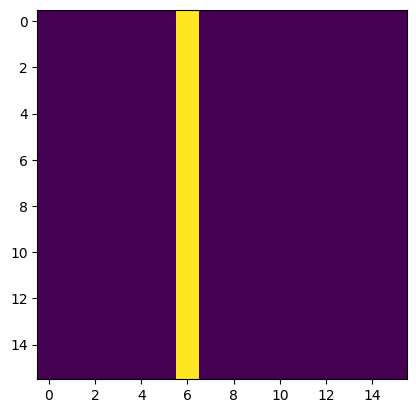

In [52]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    plt.imshow(attention, interpolation='nearest')
    plt.show()


In [46]:
attention

tensor([[4.1652e-05, 1.8743e-08, 4.3531e-15, 1.3554e-17, 2.0464e-16, 1.3552e-08,
         9.9992e-01, 1.8685e-20, 2.9881e-23, 3.2375e-22, 4.0948e-22, 5.8909e-23,
         5.1022e-18, 4.1652e-05, 1.0425e-15, 3.1295e-16],
        [6.9659e-16, 5.0016e-07, 1.9475e-12, 6.0816e-15, 4.3889e-14, 1.0717e-07,
         1.0000e+00, 1.2967e-17, 1.6856e-19, 1.3311e-18, 2.6679e-18, 2.0186e-19,
         6.4972e-16, 6.9659e-16, 3.3120e-14, 1.4395e-14],
        [2.8160e-17, 4.6376e-12, 3.3828e-09, 3.1156e-10, 7.6270e-09, 3.4791e-07,
         1.0000e+00, 1.6709e-13, 7.2155e-15, 7.7347e-15, 2.2479e-14, 1.4072e-14,
         3.9355e-12, 2.8160e-17, 7.8200e-14, 8.5553e-14],
        [8.9966e-22, 3.2495e-17, 1.8656e-13, 6.4120e-14, 1.5420e-11, 2.0936e-09,
         1.0000e+00, 3.8246e-18, 1.3870e-19, 3.8302e-19, 3.0957e-18, 2.5225e-19,
         1.7452e-17, 8.9966e-22, 3.4182e-18, 3.9053e-18],
        [1.0318e-33, 1.2762e-28, 2.2427e-30, 7.8236e-32, 1.9107e-27, 3.6965e-22,
         1.0000e+00, 3.1281e-36, 1.3927